In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators.reconciliation import ReconciliationValidator

%matplotlib inline

## 1. Load Data
Load the portfolio data from the CSV file.

In [2]:
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions.")

Loaded 7721 positions.


## 2. Run Reconciliation Validator
We run the validator to check for two types of consistency:
1.  **Intra-day**: `Close Quantity` should equal `Open Quantity` + `Traded Today`.
2.  **Inter-day**: `Open Quantity` today should equal `Close Quantity` from the previous day.

In [3]:
validator = ReconciliationValidator(positions, trades)
errors = validator.validate()

print(f"Found {len(errors)} reconciliation errors.")

if errors:
    # Convert to DataFrame for easier analysis
    error_df = pd.DataFrame([vars(e) for e in errors])
    
    # Show distribution of severity
    print("\nSeverity Distribution:")
    print(error_df['severity'].value_counts())
    
    # Show distribution of error types
    print("\nError Type Distribution:")
    print(error_df['error_type'].value_counts())
    
    display(error_df.head(10))
else:
    print("No reconciliation errors found.")

Found 19 reconciliation errors.

Severity Distribution:
severity
Medium    14
High       4
Low        1
Name: count, dtype: int64

Error Type Distribution:
error_type
Reconciliation Error (Inter-day)    19
Name: count, dtype: int64


,date,ticker,error_type,description,severity
0,2022-08-23,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -983.00 != Prev Close...,Medium
1,2022-08-24,AMC,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1310.00 != Prev Clos...,Medium
2,2022-05-12,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -251.00 != Prev Close...,Medium
3,2022-05-19,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -183.00 != Prev Close...,Medium
4,2022-05-20,AMZN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -9.00 != Prev Close -...,High
5,2022-06-23,CORN,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -4000.00 != Prev Clos...,Medium
6,2022-08-03,EXS1,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -2825.00 != Prev Clos...,High
7,2022-11-07,EXS2,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -6450.00 != Prev Clos...,High
8,2022-11-28,EXS2,Reconciliation Error (Inter-day),Inter-day Mismatch: Open 6450.00 != Prev Close...,High
9,2022-10-11,QQQ,Reconciliation Error (Inter-day),Inter-day Mismatch: Open -1722.00 != Prev Clos...,Low


## 3. Visualization: Intra-day Discrepancies
We visualize the magnitude of **Intra-day** discrepancies.
*   **X-Axis**: Expected Close (`Open` + `Traded`)
*   **Y-Axis**: Actual Close (`Close Quantity`)

Points off the diagonal line indicate days where the math does not add up within the day.

In [4]:
if errors:
    # Filter for Intra-day errors for this plot
    intra_errors = [e for e in errors if "Intra-day" in e.error_type]
    
    if intra_errors:
        # Re-calculate for plotting context
        df = positions.copy()
        cols = ["Close Quantity", "Open Quantity", "Traded Today"]
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)  # type: ignore
            
        df["Expected_Close"] = df["Open Quantity"] + df["Traded Today"]
        
        # Identify error rows
        error_keys = set((e.date, e.ticker) for e in intra_errors)
        # Map severity
        severity_map = {(e.date, e.ticker): e.severity for e in intra_errors}
        
        df['Is_Error'] = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
        df['Severity'] = df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker']), 'None'), axis=1)
        
        plt.figure(figsize=(12, 12))
        
        # 1. Plot "Valid" points
        valid_data = df[~df['Is_Error']]
        # Use abs() for log scale, but keep logic in mind
        plt.scatter(valid_data["Expected_Close"].abs(), valid_data["Close Quantity"].abs(), 
                    alpha=0.1, c='blue', label='Valid', s=10)
        
        # 2. Plot Errors by Severity
        high = df[df['Severity'] == 'High']
        med = df[df['Severity'] == 'Medium']
        low = df[df['Severity'] == 'Low']
        
        if not low.empty:
            plt.scatter(low["Expected_Close"].abs(), low["Close Quantity"].abs(), c='green', label='Low Severity', s=20, alpha=0.6)
        if not med.empty:
            plt.scatter(med["Expected_Close"].abs(), med["Close Quantity"].abs(), c='orange', label='Medium Severity', s=40, alpha=0.8)
        if not high.empty:
            plt.scatter(high["Expected_Close"].abs(), high["Close Quantity"].abs(), c='red', label='High Severity', s=60, alpha=1.0)
        
        # Annotate High Severity Errors
        annotated_tickers = set()
        for idx, row in high.iterrows():
            if row['P_Ticker'] not in annotated_tickers:
                plt.annotate(f"{row['P_Ticker']}", 
                             (abs(row['Expected_Close']), abs(row['Close Quantity'])),
                             xytext=(5, 5), textcoords='offset points',
                             fontsize=9, color='darkred', fontweight='bold')
                annotated_tickers.add(row['P_Ticker'])
                if len(annotated_tickers) >= 10: break

        # Diagonal line
        max_val = max(df["Expected_Close"].abs().max(), df["Close Quantity"].abs().max())
        # Handle 0 for log scale
        min_val = min(df[df["Expected_Close"].abs() > 0]["Expected_Close"].abs().min(), 
                      df[df["Close Quantity"].abs() > 0]["Close Quantity"].abs().min())
        if pd.isna(min_val) or min_val == 0: min_val = 0.01
        
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        plt.title("Intra-day Reconciliation: Actual vs Expected Close (Log Scale)")
        plt.xlabel("Expected Close (Open + Traded) - Log Scale")
        plt.ylabel("Actual Close Quantity - Log Scale")
        plt.legend()
        plt.grid(True)
        
        plt.xscale('log')
        plt.yscale('log')
        
        plt.show()
    else:
        print("No Intra-day errors to visualize.")

No Intra-day errors to visualize.


## 4. Visualization: Inter-day Discrepancies
We visualize the magnitude of **Inter-day** discrepancies.
*   **X-Axis**: Expected Open (`Prev Close`)
*   **Y-Axis**: Actual Open (`Open Quantity`)

Points off the diagonal line indicate days where the position changed overnight without explanation.


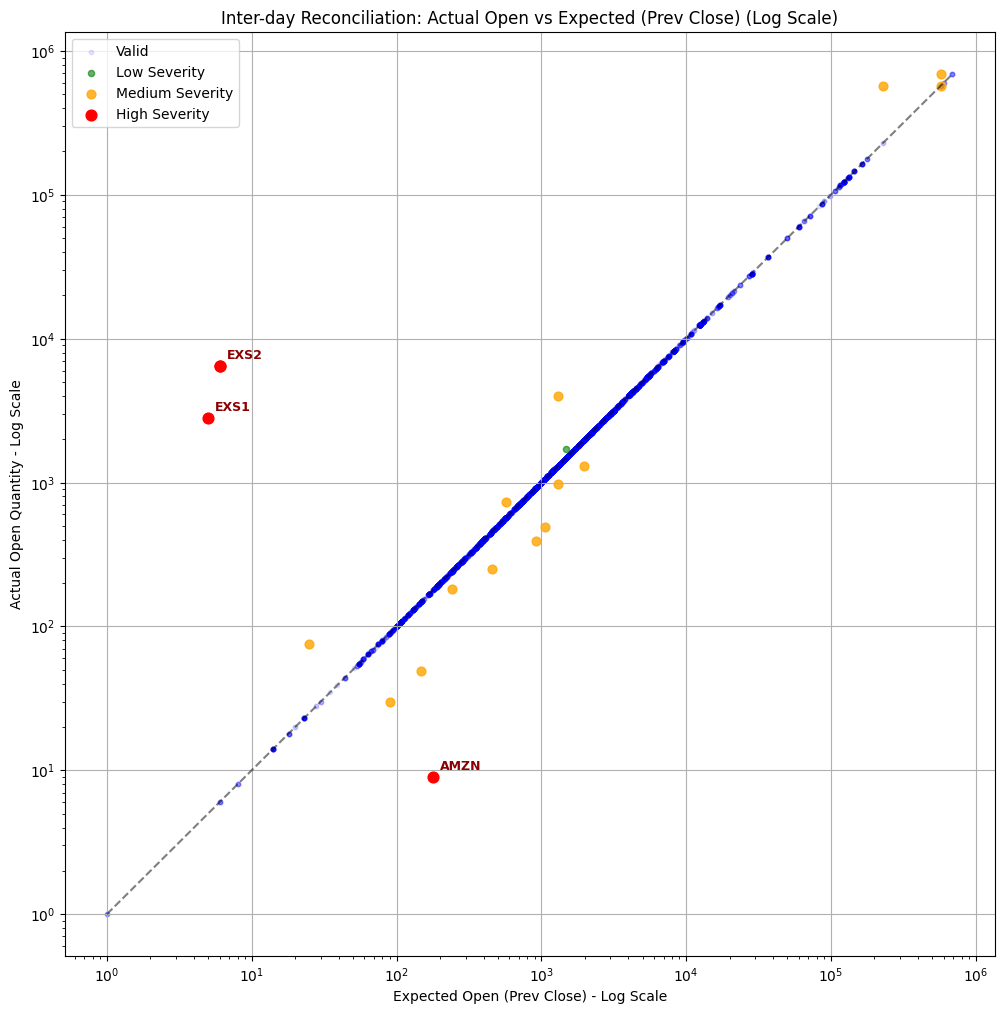

In [5]:
if errors:
    # Filter for Inter-day errors for this plot
    inter_errors = [e for e in errors if "Inter-day" in e.error_type]
    
    if inter_errors:
        # Re-calculate for plotting context
        df = positions.copy()
        cols = ["Close Quantity", "Open Quantity"]
        for col in cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        # Sort to get Prev Close
        df = df.sort_values(by=["P_Ticker", "Date"])
        df["Prev_Close"] = df.groupby("P_Ticker")["Close Quantity"].shift(1)
        
        # Identify error rows
        error_keys = set((e.date, e.ticker) for e in inter_errors)
        # Map severity
        severity_map = {(e.date, e.ticker): e.severity for e in inter_errors}
        
        df['Is_Error'] = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
        df['Severity'] = df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker']), 'None'), axis=1)
        
        plt.figure(figsize=(12, 12))
        
        # 1. Plot "Valid" points
        # We only care about rows where we have both Open and Prev_Close (and no error)
        valid_data = df[~df['Is_Error'] & df['Open Quantity'].notna() & df['Prev_Close'].notna()]
        
        plt.scatter(valid_data["Prev_Close"].abs(), valid_data["Open Quantity"].abs(), 
                    alpha=0.1, c='blue', label='Valid', s=10)
        
        # 2. Plot Errors by Severity
        high = df[df['Severity'] == 'High']
        med = df[df['Severity'] == 'Medium']
        low = df[df['Severity'] == 'Low']
        
        if not low.empty:
            plt.scatter(low["Prev_Close"].abs(), low["Open Quantity"].abs(), c='green', label='Low Severity', s=20, alpha=0.6)
        if not med.empty:
            plt.scatter(med["Prev_Close"].abs(), med["Open Quantity"].abs(), c='orange', label='Medium Severity', s=40, alpha=0.8)
        if not high.empty:
            plt.scatter(high["Prev_Close"].abs(), high["Open Quantity"].abs(), c='red', label='High Severity', s=60, alpha=1.0)
        
        # Annotate High Severity Errors
        annotated_tickers = set()
        for idx, row in high.iterrows():
            if row['P_Ticker'] not in annotated_tickers:
                plt.annotate(f"{row['P_Ticker']}", 
                             (abs(row['Prev_Close']), abs(row['Open Quantity'])),
                             xytext=(5, 5), textcoords='offset points',
                             fontsize=9, color='darkred', fontweight='bold')
                annotated_tickers.add(row['P_Ticker'])
                if len(annotated_tickers) >= 10: break

        # Diagonal line
        # Handle NaNs for max/min calculation
        max_val = max(df["Prev_Close"].abs().max(), df["Open Quantity"].abs().max())
        if pd.isna(max_val): max_val = 1
        
        # Handle 0 for log scale
        min_val = min(df[df["Prev_Close"].abs() > 0]["Prev_Close"].abs().min(), 
                      df[df["Open Quantity"].abs() > 0]["Open Quantity"].abs().min())
        if pd.isna(min_val) or min_val == 0: min_val = 0.01
        
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        plt.title("Inter-day Reconciliation: Actual Open vs Expected (Prev Close) (Log Scale)")
        plt.xlabel("Expected Open (Prev Close) - Log Scale")
        plt.ylabel("Actual Open Quantity - Log Scale")
        plt.legend()
        plt.grid(True)
        
        plt.xscale('log')
        plt.yscale('log')
        
        plt.show()
    else:
        print("No Inter-day errors to visualize.")

## 5. Time Series Analysis: Intra-day Errors
Here we visualize the **Intra-day** errors over time.
*   **Blue Line**: Reported `Close Quantity`.
*   **Orange Dashed Line**: Calculated `Open` + `Traded`.
*   **Red Markers**: Discrepancies.

This helps us see if the error is a one-off spike or a persistent offset.


In [6]:
def clean_float(x):
    try:
        return float(str(x).replace(',', '').replace(' ', ''))
    except:
        return 0.0

def visualize_intra_day_error(ticker, error_list, positions_df):
    # Filter errors for this ticker
    ticker_errors = [e for e in error_list if e.ticker == ticker and "Intra-day" in e.error_type]
    if not ticker_errors:
        return

    print(f"Visualizing Intra-day errors for: {ticker} (Count: {len(ticker_errors)})")
    
    # Prepare data
    ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
    ticker_df = ticker_df.sort_values('Date')
    
    ticker_df['Close'] = ticker_df['Close Quantity'].apply(clean_float)
    ticker_df['Open'] = ticker_df['Open Quantity'].apply(clean_float)
    ticker_df['Traded'] = pd.to_numeric(ticker_df['Traded Today'], errors='coerce') # Keep NaN
    ticker_df['Expected_Close'] = ticker_df['Open'] + ticker_df['Traded'].fillna(0) # Fill 0 for calc, but keep in mind
    
    plt.figure(figsize=(14, 5))
    
    plt.plot(ticker_df['Date'], ticker_df['Close'], label='Actual Close', color='blue', linewidth=2, alpha=0.7)
    plt.plot(ticker_df['Date'], ticker_df['Expected_Close'], label='Expected Close (Open+Traded)', color='orange', linestyle='--', linewidth=2)
    
    # Highlight errors
    error_dates = [e.date for e in ticker_errors]
    error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
    
    if not error_points.empty:
        # Plot Actual point
        plt.scatter(error_points['Date'], error_points['Close'], color='red', s=80, zorder=5, label='Intra-day Error')
        # Plot Expected point
        plt.scatter(error_points['Date'], error_points['Expected_Close'], color='green', s=80, zorder=5, marker='x', label='Expected Value')
        
        # Draw vertical lines connecting them
        for _, row in error_points.iterrows():
            plt.plot([row['Date'], row['Date']], [row['Close'], row['Expected_Close']], 
                     color='red', linestyle=':', linewidth=1.5, alpha=0.6)

    plt.title(f"Intra-day Reconciliation: {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Filter for High Severity Intra-day errors
intra_high = [e for e in errors if e.severity == 'High' and "Intra-day" in e.error_type]

if intra_high:
    # Count recurrence
    from collections import Counter
    ticker_counts = Counter(e.ticker for e in intra_high)
    top_tickers = [t[0] for t in ticker_counts.most_common(3)]
    
    print(f"Visualizing top {len(top_tickers)} tickers with High Severity Intra-day errors.")
    for ticker in top_tickers:
        visualize_intra_day_error(ticker, intra_high, positions)
else:
    print("No High Severity Intra-day errors found.")

No High Severity Intra-day errors found.


## 6. Time Series Analysis: Inter-day Errors
Here we visualize **Inter-day** errors.
*   **Blue Line**: `Open Quantity` (Today).
*   **Purple Dashed Line**: `Close Quantity` (Yesterday).

A gap here means the position changed overnight without a trade record, or the data is inconsistent.

Visualizing top 3 tickers with High Severity Inter-day errors.
Visualizing Inter-day errors for: EXS2 (Count: 2)


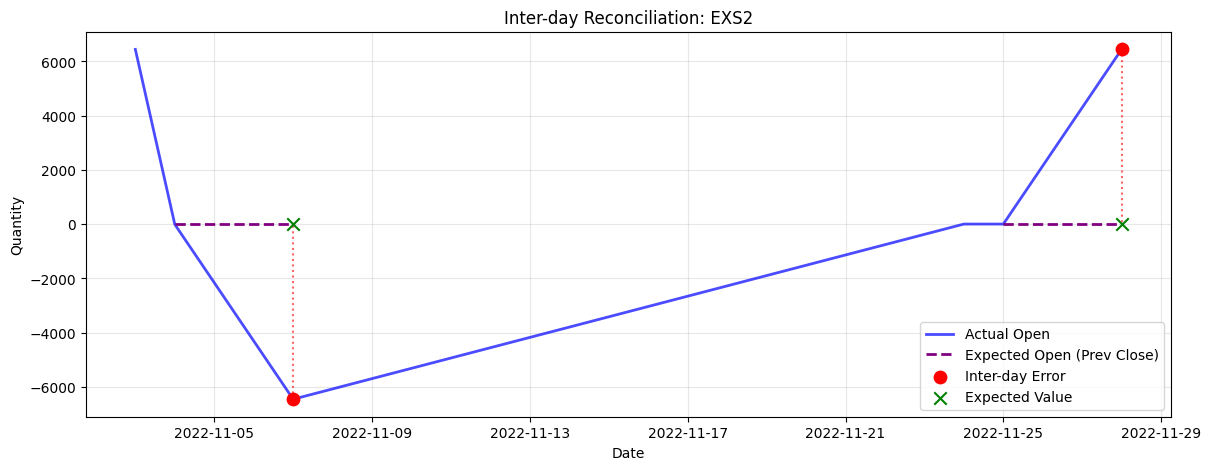

Visualizing Inter-day errors for: AMZN (Count: 1)


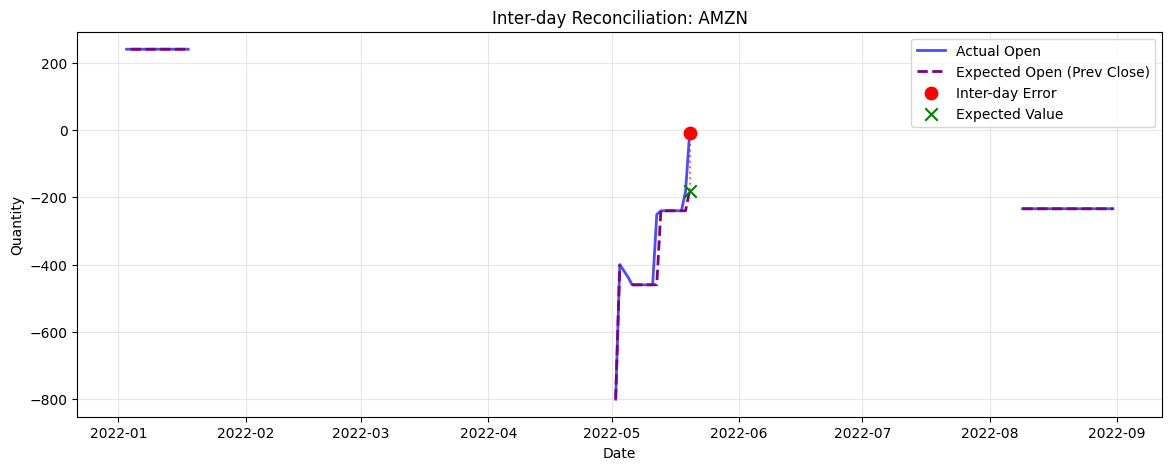

Visualizing Inter-day errors for: EXS1 (Count: 1)


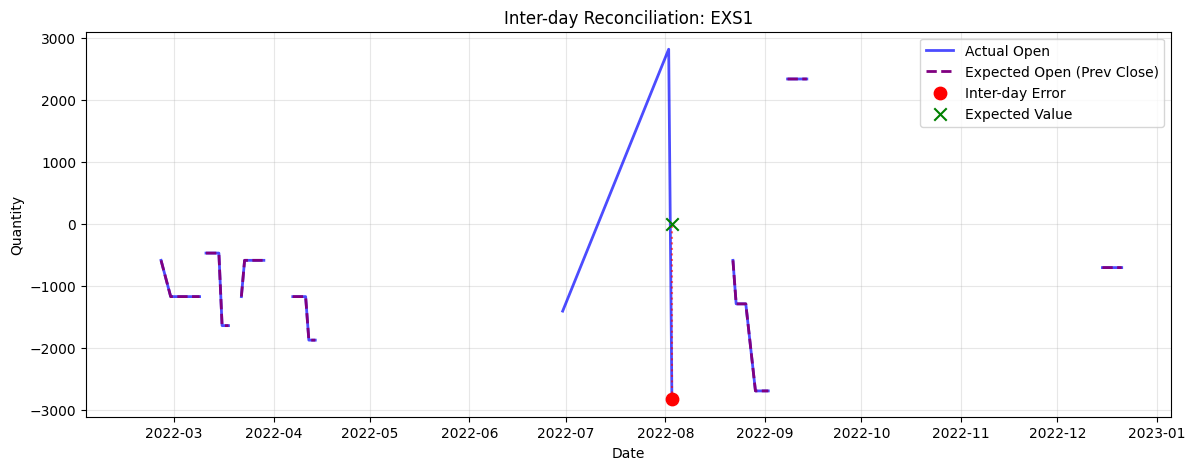

In [7]:
def visualize_inter_day_error(ticker, error_list, positions_df):
    # Filter errors for this ticker
    ticker_errors = [e for e in error_list if e.ticker == ticker and "Inter-day" in e.error_type]
    if not ticker_errors:
        return

    print(f"Visualizing Inter-day errors for: {ticker} (Count: {len(ticker_errors)})")
    
    # Prepare data
    ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])
    ticker_df = ticker_df.sort_values('Date')
    
    ticker_df['Open'] = ticker_df['Open Quantity'].apply(clean_float)
    ticker_df['Close'] = ticker_df['Close Quantity'].apply(clean_float)
    ticker_df['Prev_Close'] = ticker_df['Close'].shift(1)
    
    plt.figure(figsize=(14, 5))
    
    plt.plot(ticker_df['Date'], ticker_df['Open'], label='Actual Open', color='blue', linewidth=2, alpha=0.7)
    plt.plot(ticker_df['Date'], ticker_df['Prev_Close'], label='Expected Open (Prev Close)', color='purple', linestyle='--', linewidth=2)
    
    # Highlight errors
    error_dates = [e.date for e in ticker_errors]
    error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
    
    if not error_points.empty:
        # Plot Actual Open
        plt.scatter(error_points['Date'], error_points['Open'], color='red', s=80, zorder=5, label='Inter-day Error')
        
        # Plot Expected Open (Prev Close)
        # Note: Prev_Close might be NaN if error is on first day (though unlikely for Inter-day check)
        valid_points = error_points.dropna(subset=['Prev_Close'])
        
        if not valid_points.empty:
            plt.scatter(valid_points['Date'], valid_points['Prev_Close'], color='green', s=80, zorder=5, marker='x', label='Expected Value')
            
            # Draw vertical lines
            for _, row in valid_points.iterrows():
                plt.plot([row['Date'], row['Date']], [row['Open'], row['Prev_Close']], 
                         color='red', linestyle=':', linewidth=1.5, alpha=0.6)

    plt.title(f"Inter-day Reconciliation: {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Filter for High Severity Inter-day errors
inter_high = [e for e in errors if e.severity == 'High' and "Inter-day" in e.error_type]

if inter_high:
    # Count recurrence
    from collections import Counter
    ticker_counts = Counter(e.ticker for e in inter_high)
    top_tickers = [t[0] for t in ticker_counts.most_common(3)]
    
    print(f"Visualizing top {len(top_tickers)} tickers with High Severity Inter-day errors.")
    for ticker in top_tickers:
        visualize_inter_day_error(ticker, inter_high, positions)
else:
    print("No High Severity Inter-day errors found.")